In [2]:
import pandas as pd

xls = pd.ExcelFile("olist_data.xlsx")

print(xls.sheet_names)

orders = pd.read_excel(xls, "olist_orders_dataset")
customers = pd.read_excel(xls, "olist_customers_dataset")
products = pd.read_excel(xls, "olist_products_dataset")
order_items = pd.read_excel(xls, "olist_order_items_dataset")
payments = pd.read_excel(xls, "olist_order_payments_dataset")
reviews = pd.read_excel(xls, "olist_order_reviews_dataset")
geolocation = pd.read_excel(xls, "olist_geolocation_dataset")
category = pd.read_excel(xls, "product_category_name_translati")
seller = pd.read_excel(xls, "olist_sellers_dataset")




['olist_order_reviews_dataset', 'product_category_name_translati', 'olist_customers_dataset', 'olist_sellers_dataset', 'olist_products_dataset', 'olist_orders_dataset', 'olist_order_payments_dataset', 'olist_order_items_dataset', 'olist_geolocation_dataset']


In [3]:
pip install pandasql


Note: you may need to restart the kernel to use updated packages.


# A. Customer and Order Analysis

## 1. Order & revenue trends

In [4]:

from pandasql import sqldf

q = """
SELECT
  strftime('%Y-%m', order_purchase_timestamp) AS month,
  COUNT(DISTINCT order_id) AS orders,
  SUM(price) AS gmv,
  AVG(price) AS aov
FROM orders
JOIN order_items USING(order_id)
WHERE order_status = 'delivered'
GROUP BY 1
ORDER BY 1;
"""
result = sqldf(q, locals())   
print(result)


      month  orders        gmv         aov
0   2016-09       1     134.97   44.990000
1   2016-10     265   40325.11  128.834217
2   2016-12       1      10.90   10.900000
3   2017-01     750  111798.36  122.451654
4   2017-02    1653  234223.40  126.062110
5   2017-03    2546  359198.85  123.989938
6   2017-04    2303  340669.68  132.607894
7   2017-05    3546  489338.25  122.212350
8   2017-06    3135  421923.37  120.929599
9   2017-07    3872  481604.52  109.058995
10  2017-08    4193  554699.70  115.634709
11  2017-09    4150  607399.67  128.224545
12  2017-10    4478  648247.65  124.328280
13  2017-11    7289  987765.37  116.550486
14  2017-12    5513  726033.19  117.348180
15  2018-01    7069  924645.00  115.048526
16  2018-02    6555  826437.13  109.927791
17  2018-03    7003  953356.25  118.916833
18  2018-04    6798  973534.09  124.381511
19  2018-05    6749  977544.69  125.165773
20  2018-06    6099  856077.86  122.122377
21  2018-07    6159  867953.46  124.652227
22  2018-08

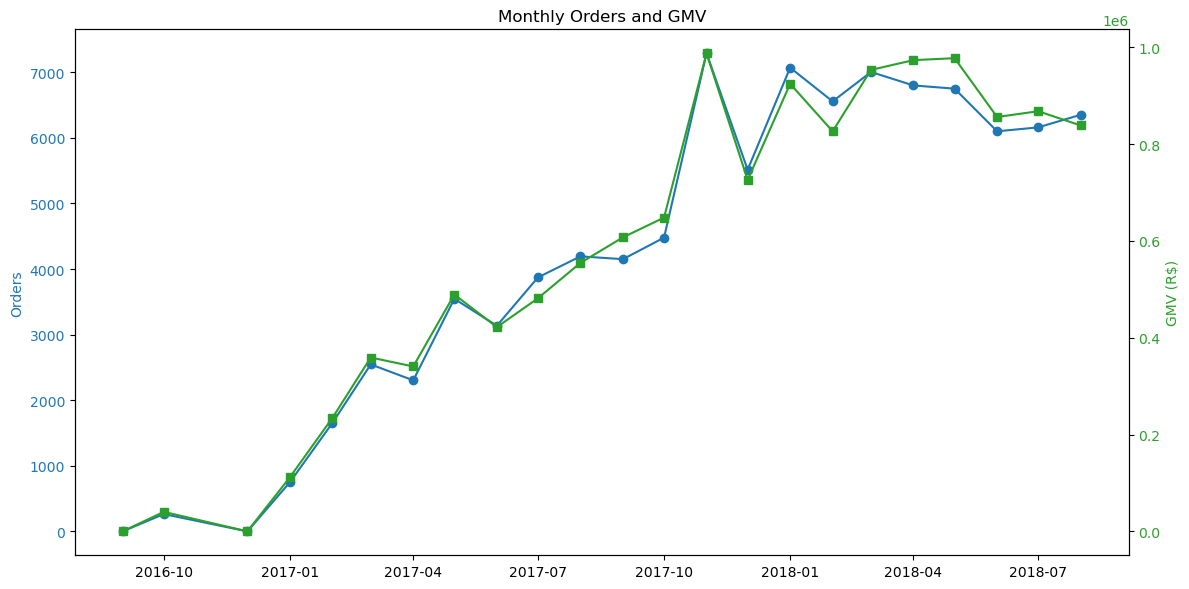

In [5]:
import matplotlib.pyplot as plt

result['month'] = pd.to_datetime(result['month'])

fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(result['month'], result['orders'], color='tab:blue', marker='o', label='Orders')
ax1.set_ylabel("Orders", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(result['month'], result['gmv'], color='tab:green', marker='s', label='GMV')
ax2.set_ylabel("GMV (R$)", color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

plt.title("Monthly Orders and GMV")
fig.tight_layout()
plt.show()


#### Insights:
*  From late 2016 to late 2017, both orders and GMV grew sharply
*  Orders rose from just a handful in late 2016 to 7,000+ per month by late 2017.
*  Growth is driven more by volume of orders than by customers spending more per order. 
*  Notice the huge peak in Nov 2017 (likely Black Friday). 
*  After the Black Friday spike, volumes stabilize around 6,000–7,000 monthly
#### Takeaways

* Olist’s success hinges on scaling customers and orders, not higher order values.

* Seasonality (Black Friday, holidays) is a major growth driver in Brazilian e-commerce.

* After rapid growth in 2017, the marketplace stabilized at a high baseline in 2018.

## 2. Geolocation analysis

In [6]:
q = """
SELECT
  customer_state,
  COUNT(DISTINCT customer_id) AS n_customers,
  ROUND(100.0 * COUNT(DISTINCT customer_id) / 
        (SELECT COUNT(DISTINCT customer_id) FROM customers), 2) AS pct_customers
FROM customers
GROUP BY customer_state
ORDER BY n_customers DESC
"""
result = sqldf(q, locals()) 
print(result)

   customer_state  n_customers  pct_customers
0              SP        41746          41.98
1              RJ        12852          12.92
2              MG        11635          11.70
3              RS         5466           5.50
4              PR         5045           5.07
5              SC         3637           3.66
6              BA         3380           3.40
7              DF         2140           2.15
8              ES         2033           2.04
9              GO         2020           2.03
10             PE         1652           1.66
11             CE         1336           1.34
12             PA          975           0.98
13             MT          907           0.91
14             MA          747           0.75
15             MS          715           0.72
16             PB          536           0.54
17             PI          495           0.50
18             RN          485           0.49
19             AL          413           0.42
20             SE          350    

In [7]:

q = """
SELECT
  customer_city,
  COUNT(DISTINCT customer_id) AS n_customers,
    ROUND(
    100.0 * COUNT(DISTINCT customer_id) / 
    (SELECT COUNT(DISTINCT customer_id) FROM customers), 2
  ) AS pct_customers
FROM customers
GROUP BY customer_city
ORDER BY n_customers DESC
LIMIT 10;
"""
result = sqldf(q, locals())   
print(result)


           customer_city  n_customers  pct_customers
0              sao paulo        15540          15.63
1         rio de janeiro         6882           6.92
2         belo horizonte         2773           2.79
3               brasilia         2131           2.14
4               curitiba         1521           1.53
5               campinas         1444           1.45
6           porto alegre         1379           1.39
7               salvador         1245           1.25
8              guarulhos         1189           1.20
9  sao bernardo do campo          938           0.94


In [8]:
q = """
SELECT
  seller_state,
  COUNT(DISTINCT seller_id) AS n_sellers,
    ROUND(
    100.0 * COUNT(DISTINCT seller_id) / 
    (SELECT COUNT(DISTINCT seller_id) FROM seller), 2
  ) AS pct_sellers
FROM seller
GROUP BY seller_state
ORDER BY n_sellers DESC

"""
result = sqldf(q, locals())   
print(result)

   seller_state  n_sellers  pct_sellers
0            SP       1849        59.74
1            PR        349        11.28
2            MG        244         7.88
3            SC        190         6.14
4            RJ        171         5.53
5            RS        129         4.17
6            GO         40         1.29
7            DF         30         0.97
8            ES         23         0.74
9            BA         19         0.61
10           CE         13         0.42
11           PE          9         0.29
12           PB          6         0.19
13           RN          5         0.16
14           MS          5         0.16
15           MT          4         0.13
16           SE          2         0.06
17           RO          2         0.06
18           PI          1         0.03
19           PA          1         0.03
20           MA          1         0.03
21           AM          1         0.03
22           AC          1         0.03


#### Insights:
#### Customer
* Heavy concentration in the Southeast, São Paulo (SP) dominates (41.98%)
* SP + RJ + MG account for ~64% of total customers.
                      
#### Sellers
* Seller base is also concentrated in SP (59.74%)
* Paraná (PR), Minas Gerais (MG), Santa Catarina (SC), and Rio de Janeiro (RJ) follow with far fewer sellers.

#### 💡 Takeaways

* Customers are spread more widely across Brazil (even in remote states like AC, RR, AP).

* Sellers are concentrated in a few states (SP especially)

* This geographic imbalance likely drives long shipping distances.

## Delivery time and effectiveness analysis


In [9]:
q = """
SELECT
  SUM(CASE WHEN order_delivered_customer_date <= order_estimated_delivery_date THEN 1 ELSE 0 END) * 1.0
    / COUNT(*) AS on_time_rate,
  SUM(CASE WHEN order_delivered_customer_date > order_estimated_delivery_date THEN 1 ELSE 0 END) * 1.0
    / COUNT(*) AS late_rate,
  COUNT(*) AS total_orders
FROM orders
WHERE order_status = 'delivered';
"""
result = sqldf(q, locals())   
print(result)

   on_time_rate  late_rate  total_orders
0        0.9188   0.081117         96478


In [10]:
q = """ SELECT
    customer_state, 
    AVG(delivery_days) AS avg_delivery_time
FROM (
        SELECT 
  customer_id, 
  ROUND(JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_purchase_timestamp), 2) AS delivery_days,
  COUNT(*) AS n_orders
  FROM orders 
        WHERE order_status='delivered'
      GROUP BY 1 ) as o
LEFT JOIN customers AS c ON o.customer_id = c.customer_id
GROUP BY 1
ORDER BY 2;
"""
result = sqldf(q, locals())   
print(result)

   customer_state  avg_delivery_time
0              SP           8.761356
1              PR          11.991574
2              MG          12.008631
3              DF          12.967620
4              SC          14.954808
5              RS          15.300258
6              RJ          15.309440
7              GO          15.606280
8              MS          15.618331
9              ES          15.789303
10             TO          17.657883
11             MT          18.055801
12             PE          18.448349
13             RN          19.278418
14             BA          19.335430
15             RO          19.372099
16             PI          19.457122
17             PB          20.426615
18             AC          21.035250
19             CE          21.266575
20             SE          21.519701
21             MA          21.573138
22             PA          23.772970
23             AL          24.543980
24             AM          26.425862
25             AP          27.185224
2

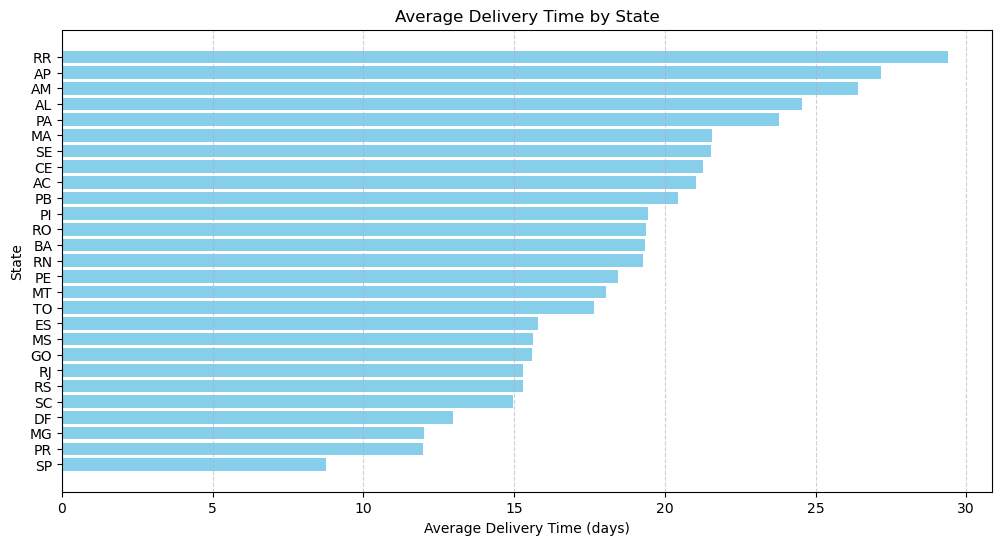

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

result_sorted = result.sort_values("avg_delivery_time", ascending=True)

plt.barh(result_sorted["customer_state"], result_sorted["avg_delivery_time"], color="skyblue")
plt.xlabel("Average Delivery Time (days)")
plt.ylabel("State")
plt.title("Average Delivery Time by State")
plt.grid(axis="x", linestyle="--", alpha=0.6)

plt.show()


   customer_state  freight_cost_percent
0              SP                 13.81
1              MS                 16.39
2              DF                 16.73
3              RJ                 16.75
4              MG                 17.09
5              SC                 17.22
6              PR                 17.25
7              GO                 18.03
8              RS                 18.06
9              ES                 18.09
10             MT                 18.99
11             BA                 19.59
12             AL                 19.82
13             AP                 20.69
14             CE                 21.28
15             PA                 21.63
16             PB                 22.31
17             PE                 22.62
18             RN                 22.71
19             AC                 23.07
20             TO                 23.64
21             SE                 23.95
22             PI                 24.41
23             AM                 24.51


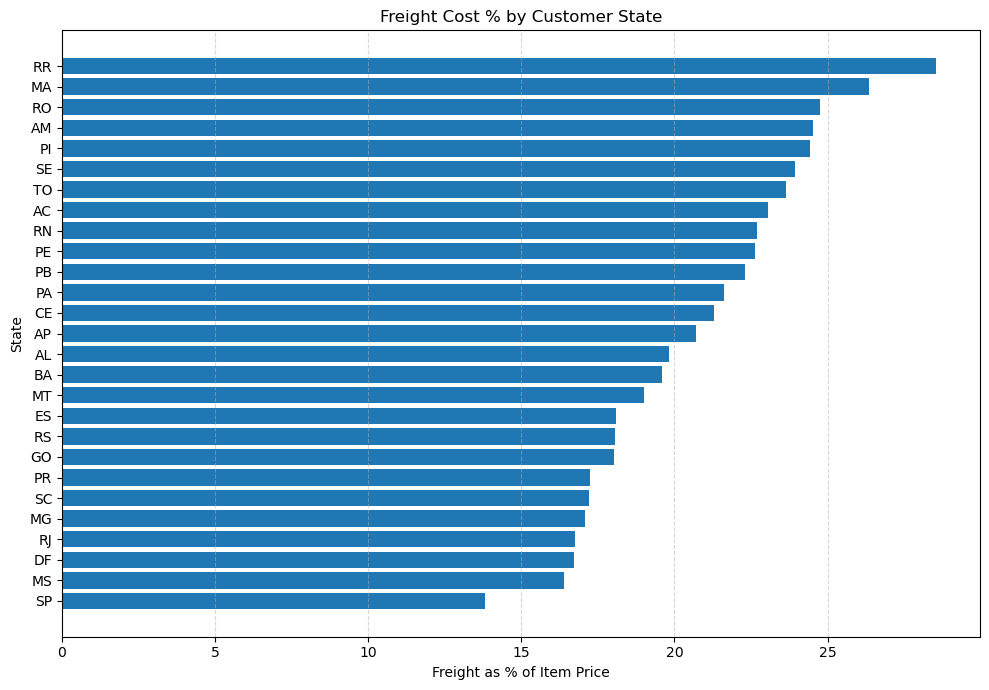

In [12]:
q = """ SELECT 
    customer_state, 
    ROUND((SUM(freight_value) / SUM(price)) * 100, 2) as freight_cost_percent 
FROM 
    (
      SELECT 
          o.order_id, 
          o.customer_id, 
          customer_state, 
          price, 
          freight_value 
      FROM 
          orders AS o 
          LEFT JOIN order_items AS oi ON o.order_id = oi.order_id 
          LEFT JOIN customers AS c ON o.customer_id = c.customer_id
    ) AS t
GROUP BY 1
ORDER BY 2; """
result = sqldf(q, locals())   
print(result)

df = result.copy()
df.columns = df.columns.str.strip().str.lower()
df = df.sort_values('freight_cost_percent', ascending=True)

plt.figure(figsize=(10,7))
plt.barh(df['customer_state'], df['freight_cost_percent'])
plt.xlabel('Freight as % of Item Price')
plt.ylabel('State')
plt.title('Freight Cost % by Customer State')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Insights: 
* There is a strong correlation between the number of sellers in the region and the average order delivery speed: 
in the southeastern regions with a high concentration of sellers (Sao Paolo, Parana, Minas Gerais), the average delivery speed is less than two weeks. In the northern and northwestern regions (Amazonas, Anapa, Roraima), the average delivery time exceeds 25 days.
* => From this we can conclude that customers in high-revenue regions use the delivery service more frequently. The average share of shipping cost of the total order value is also lower in regions with high profitability and fast (relative to other regions) delivery.

## Revenue and order price analysis by region


In [13]:
q = """ SELECT 
    customer_state, 
    AVG(payment_value) AS avg_order_price, 
    SUM(payment_value) AS total_order_price 
FROM 
    (
        SELECT 
            o.order_id, 
            o.customer_id, 
            customer_state, 
            payment_value 
        FROM 
            orders AS o 
            LEFT JOIN payments AS op ON o.order_id = op.order_id 
            LEFT JOIN customers AS c ON o.customer_id = c.customer_id
    ) AS t
GROUP BY 1
ORDER BY 3 DESC; """
result = sqldf(q, locals())  
print(result)

   customer_state  avg_order_price  total_order_price
0              SP       137.504630         5998226.96
1              RJ       158.525888         2144379.69
2              MG       154.706434         1872257.26
3              RS       157.180406          890898.54
4              PR       154.153626          811156.38
5              SC       165.979337          623086.43
6              BA       170.816017          616645.82
7              DF       161.134791          355141.08
8              GO       165.763404          350092.31
9              ES       154.706953          325967.55
10             PE       187.992153          324850.44
11             CE       199.902740          279464.03
12             PA       215.920722          218295.85
13             MT       195.228904          187029.29
14             MA       198.856610          152523.02
15             PB       248.325825          141545.72
16             MS       186.867989          137534.84
17             PI       207.

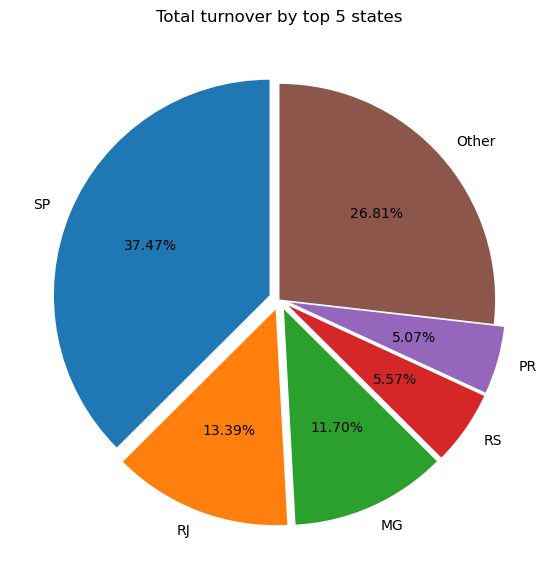

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = result.copy()  
top5 = df.sort_values("total_order_price", ascending=False).head(5)
others_val = df["total_order_price"].sum() - top5["total_order_price"].sum()
others = pd.DataFrame({"customer_state":["Other"], "total_order_price":[others_val]})
df_pie = pd.concat([top5[["customer_state","total_order_price"]], others])

plt.figure(figsize=(7,7))
plt.pie(df_pie["total_order_price"],
        labels=df_pie["customer_state"],
        autopct="%.2f%%",
        startangle=90,
        explode=[0.05 if s!="Other" else 0 for s in df_pie["customer_state"]])
plt.title("Total turnover by top 5 states")
plt.show()


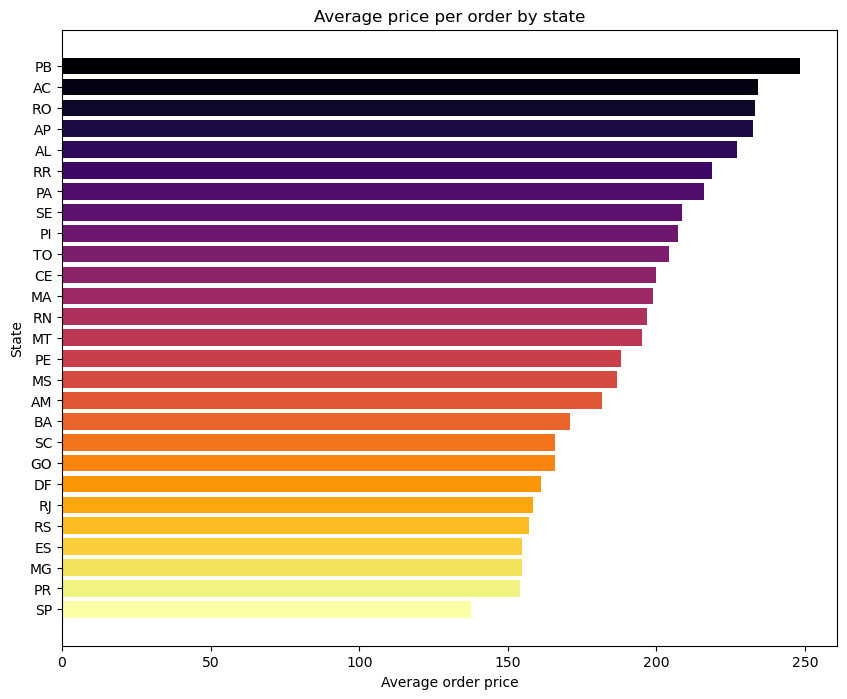

In [15]:
df_sorted = df.sort_values("avg_order_price", ascending=False)

plt.figure(figsize=(10,8))
plt.barh(df_sorted["customer_state"],
         df_sorted["avg_order_price"],
         color=plt.cm.inferno(np.linspace(0,1,len(df_sorted))))
plt.xlabel("Average order price")
plt.ylabel("State")
plt.title("Average price per order by state")
plt.gca().invert_yaxis()
plt.show()


In the pie chart "Total turnover by top 5 states", we can see that more than half of the total revenue for the study period was received from the Sao Paolo and Rio de Janeiro regions - this observation is naturally consistent with the previous observation of a high concentration of buyers in these regions. From the graph "Average price per order by state", we can observe that the average check in high-revenue regions (Sao Paolo, Rio de Janeiro, Minas Gerais, Parane) is significantly lower than the average order value in other regions.

### Customer satisfaction analysis

Let's identify the states with the best and the worst customer reviews.



   state  n_reviews  avg_review
0     AC         81    4.049383
1     AL        414    3.751208
2     AM        147    4.183673
3     AP         67    4.194030
4     BA       3357    3.860888
5     CE       1329    3.851016
6     DF       2148    4.064711
7     ES       2016    4.041667
8     GO       2024    4.042490
9     MA        746    3.764075
10    MG      11625    4.136172
11    MS        724    4.118785
12    MT        903    4.102990
13    PA        968    3.849174
14    PB        531    4.018832
15    PE       1646    4.011543
16    PI        491    3.920570
17    PR       5038    4.180032
18    RJ      12765    3.874971
19    RN        482    4.105809
20    RO        252    4.051587
21    RS       5483    4.133321
22    SC       3623    4.071764
23    SE        349    3.808023
24    SP      41690    4.173951
25    TO        279    4.096774


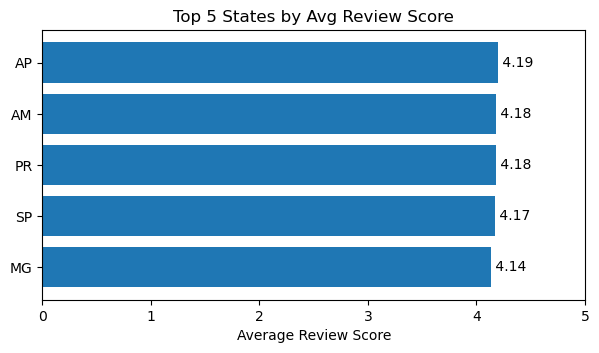

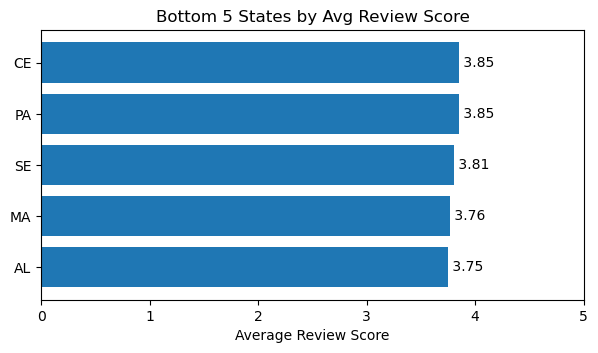

In [21]:
q = """
SELECT
  c.customer_state AS state,
  COUNT(re.review_id)                AS n_reviews,
  AVG(CAST(re.review_score AS REAL)) AS avg_review
FROM orders o
JOIN customers c
  ON o.customer_id = c.customer_id
LEFT JOIN reviews re
  ON o.order_id = re.order_id
WHERE c.customer_state IS NOT NULL
GROUP BY 1
HAVING COUNT(re.review_id) >= 50
"""
result = sqldf(q, locals())  
print(result) 
state_df = sqldf(q, locals())

top5    = state_df.sort_values(["avg_review", "n_reviews"], ascending=[False, False]).head(5)
bottom5 = state_df.sort_values(["avg_review", "n_reviews"], ascending=[True, False]).head(5)


plt.figure(figsize=(7, 3.5))
plt.barh(top5["state"], top5["avg_review"])
plt.title("Top 5 States by Avg Review Score")
plt.xlabel("Average Review Score")
plt.xlim(0, 5)  # review scores are 1..5
plt.gca().invert_yaxis()
for i, v in enumerate(top5["avg_review"]):
    plt.text(v, i, f" {v:.2f}", va="center")
plt.show()

b5 = bottom5.sort_values("avg_review", ascending=False)  # so worst appears at top
plt.figure(figsize=(7, 3.5))
plt.barh(b5["state"], b5["avg_review"])
plt.title("Bottom 5 States by Avg Review Score")
plt.xlabel("Average Review Score")
plt.xlim(0, 5)
plt.gca().invert_yaxis()
for i, v in enumerate(b5["avg_review"]):
    plt.text(v, i, f" {v:.2f}", va="center")
plt.show()


Customers are most satisfied with the quality of service in the most "active" regions: Sao Paolo, Minas Gerais, Parana). Order estimates in Roraima clearly indicate problems with the quality of service in the region.

# Conclusion

* Areas in the south and southeast of the nation that are highly profitable, have a concentration of customers who buy a lot and frequently, receive their goods fast, pay relatively little for shipping, and are generally happy with the level of service. Sao Paolo, Minas Gerais, and Parana are the three regions in this cluster with the highest performance indicators.
* Regions in the country's north and northwest with a low concentration of buyers and sellers, as well as ones with high costs and lengthy delivery times. Roraima, Alagoas, and Maranhao are the three most troublesome regions in this cluster and may be easily differentiated. In these areas, the average delivery time exceeds three weeks. Also, compared to other regions, practically all of these orders obtain reviews with rather poor scores.